In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections
from collections import defaultdict

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [ ]:
class Delaunay_Sphere(Graph, Flat):

    """Parent class of more specific graph classes (spiderweb, delaunay triangulations etc.)
    These child classes need the attributes:
        - num_Vs DONE
        - V_coords DONE
        - E_lengths_by_v_num DONE
        - interior_V_num DONE
        - wadjacency_matrix DONE
    """

    def __init__(self, num_Vs):

        self.num_Vs = num_Vs
        self.construct_data()

    def construct_data(self):

        V_coords = np.random.normal(0, 1, size=(self.num_Vs, 3))
        V_coords /= np.linalg.norm(V_coords, axis=1, keepdims=True)

        # Construct edge set by Voronoi tesselation
        radius = 1
        center = np.array([0, 0, 0])
        sv = scipy.spatial.SphericalVoronoi(V_coords, radius, center)

        # Iterate over each Voronoi vertex
        vertex_to_regions = defaultdict(list)

        # Map each Voronoi vertex to the regions it belongs to
        for point_idx, region in enumerate(sv.regions):
            for vertex in region:
                vertex_to_regions[vertex].append(point_idx)

        edges = set()
        for region in vertex_to_regions.values():
            if len(region) != 3:
                raise ValueError(("Assumption that deg(Voronoi vertex) = 3 has been broken." 
                                  + "Probably not a problem, but there will be non-triangular faces in graph."))
            new_edges = [(region[0], region[1]), (region[1], region[2]), (region[0], region[2])]
            for edge in new_edges:
                edges.add(edge)

        E_lengths_by_v_num = {}
        for v_ind, w_ind in edges:
            E_lengths_by_v_num[v_ind, w_ind] = self.length_on_sphere(V_coords[v_ind], 
                                                                      V_coords[w_ind])
        
        # # Old (MUCH slower) method: Construct edge set by Delaunay triangulation
        # V_coords = np.vstack((V_coords, np.array(([0, 0, 0]))))

        # triangulation = scipy.spatial.Delaunay(V_coords)
        # self.triangulation = triangulation
        # print("triangulation built")

        # # Construct edges
        # triangulation = scipy.spatial.Delaunay(V_coords)
        # V, W = triangulation.vertex_neighbor_vertices
        # E_lengths_by_v_num = {}
        # for v_ind in range(self.num_Vs):
        #     w_inds = W[V[v_ind]:V[v_ind + 1]]
        #     for w_ind in w_inds:
        #         if (v_ind < w_ind) and (w_ind != self.num_Vs):
        #             E_lengths_by_v_num[v_ind, w_ind] = self.length_on_sphere(V_coords[v_ind], 
        #                                                                      V_coords[w_ind])
                    
        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v_ind, w_ind in E_lengths_by_v_num:
            wadjacency_matrix[v_ind, w_ind] = E_lengths_by_v_num[v_ind, w_ind]
            wadjacency_matrix[w_ind, v_ind] = E_lengths_by_v_num[v_ind, w_ind]
        wadjacency_matrix = wadjacency_matrix.tocsc()

        self.V_coords = V_coords[:-1]
        self.E_lengths_by_v_num = E_lengths_by_v_num
        self.interior_V_num = np.arange(self.num_Vs)
        self.wadjacency_matrix = wadjacency_matrix

    def length_on_sphere(self, p1, p2, r=1):

        x1, y1, z1 = p1
        x2, y2, z2 = p2

        # Calculate the central angle between the two points
        dot_product = x1 * x2 + y1 * y2 + z1 * z2
        cos_theta = dot_product / (r**2)
        theta = np.arccos(np.clip(cos_theta, -1, 1))

        # Calculate the arc length
        arc_length = r * theta

        return arc_length

In [3]:
file = open("paper_data/delaunay_sphere_eigenvalues.pkl", "rb")
eigenvalues = pickle.load(file)
file.close()

In [11]:
0.92**0.5

0.9591663046625439

In [7]:
np.mean(eigenvalues[10000])

0.9592523853994024

In [138]:
eigenvalues[10000]

[array([0.94912181, 0.95950576, 0.9703313 ]),
 array([0.95365224, 0.96163093, 0.96314314]),
 array([0.95209623, 0.958402  , 0.96554869]),
 array([0.94751805, 0.96121772, 0.97009925]),
 array([0.95341175, 0.96012194, 0.96494743]),
 array([0.95065561, 0.96159692, 0.96548962]),
 array([0.95322795, 0.95844285, 0.96574267]),
 array([0.95237419, 0.95960245, 0.96203235]),
 array([0.95268113, 0.95776981, 0.96732124]),
 array([0.95359206, 0.96096579, 0.96344675]),
 array([0.95187984, 0.96101837, 0.96451507]),
 array([0.95098775, 0.95976851, 0.96782662]),
 array([0.95272756, 0.95998886, 0.96621239]),
 array([0.95504725, 0.95783989, 0.96412745]),
 array([0.95361946, 0.95927631, 0.9643706 ]),
 array([0.95259686, 0.95972428, 0.96688915]),
 array([0.95316217, 0.95513271, 0.97011575]),
 array([0.94958661, 0.96289522, 0.96478505]),
 array([0.95299582, 0.95916016, 0.96636038]),
 array([0.95388711, 0.95684642, 0.96737098]),
 array([0.95084627, 0.95719913, 0.96974778]),
 array([0.95330566, 0.95604869, 0.

In [139]:
nums_Vs = (10**np.linspace(2, 5, 16)).astype(int)[:12]

# eigenvalues = {}
for en, num_Vs in enumerate(nums_Vs[-1:]):
    print(f"\n\n\nGRAPH {en} / 12\n\n\n")
    eigenvalues[num_Vs] = []
    if num_Vs < 900:
        guesses = np.linspace(0.8, 1.2, 25)
        num_seeds = 256
    elif num_Vs < 4000:
        guesses = np.linspace(0.88, 1.05, 12)
        num_seeds = 128
    elif num_Vs < 50000:
        guesses = np.linspace(0.94, 0.97, 8)
        num_seeds = 32
    else:
        num_seeds = 1
        guesses = np.array([0.95, 0.955, 0.959, 0.964, 0.968, 0.971])
    for seed in range(num_seeds):
        print(f"seed = {seed}")
        np.random.seed(seed)
        g = Delaunay_Sphere(num_Vs)
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        solutions = []
        for guess in guesses:
            solution = eigs(guess, solve_type="SVD iterate", printerval=np.inf, tol=1e-4, max_steps=20)
            solutions.append(solution)
            _, index = np.unique(np.round(solutions, 3), return_index=True)
            solutions = list(np.array(solutions)[index])
        full_solutions = eigs(solutions, solve_type="SVD iterate", printerval=np.inf, tol=1e-13, max_steps=20)
        print(g.num_Vs)
        print(np.unique(np.round(full_solutions, 8)))
        print()
        _, inds = np.unique(np.round(full_solutions, 8), return_index=True)
        eigenvalues[num_Vs].append(full_solutions[inds])




GRAPH 0 / 12



seed = 0
15848
[0.95448205 0.95814217 0.96443057]

seed = 1
15848
[0.95386616 0.95934379 0.966954  ]

seed = 2
15848
[0.94993756 0.95695383 0.96967284]

seed = 3
15848
[0.95166106 0.96051534 0.9655361 ]

seed = 4
15848
[0.95513245 0.96127064]

seed = 5
15848
[0.95253913 0.96125614 0.96345621]

seed = 6
15848
[0.95340176 0.96182889 0.96410957]

seed = 7
15848
[0.95047201 0.96179725 0.96424768]

seed = 8
15848
[0.95659254 0.9633932 ]

seed = 9
15848
[0.95365469 0.95779612 0.96629812]

seed = 10
15848
[0.95368613 0.95676992 0.96728046]

seed = 11
15848
[0.95105135 0.96067701 0.9665284 ]

seed = 12
15848
[0.9558328  0.96065046]

seed = 13
15848
[0.95366116 0.95741714 0.9659526 ]

seed = 14
15848
[0.95300597 0.95871826 0.96409866]

seed = 15
15848
[0.95553556 0.95769287 0.96415557]

seed = 16
15848
[0.95738006 0.96191707]

seed = 17
15848
[0.95475013 0.96116082 0.96186487]

seed = 18
15848
[0.95241363 0.95943597 0.96706613]

seed = 19
15848
[0.95218965 0.95956558 0.967075

In [140]:
eigenvalues[nums_Vs[-1]]

[array([0.95448205, 0.95814217, 0.96443057]),
 array([0.95386616, 0.95934379, 0.966954  ]),
 array([0.94993756, 0.95695383, 0.96967284]),
 array([0.95166106, 0.96051534, 0.9655361 ]),
 array([0.95513245, 0.96127064]),
 array([0.95253913, 0.96125614, 0.96345621]),
 array([0.95340176, 0.96182889, 0.96410957]),
 array([0.95047201, 0.96179725, 0.96424768]),
 array([0.95659254, 0.9633932 ]),
 array([0.95365469, 0.95779612, 0.96629812]),
 array([0.95368613, 0.95676992, 0.96728046]),
 array([0.95105135, 0.96067701, 0.9665284 ]),
 array([0.9558328 , 0.96065046]),
 array([0.95366116, 0.95741714, 0.9659526 ]),
 array([0.95300597, 0.95871826, 0.96409866]),
 array([0.95553556, 0.95769287, 0.96415557]),
 array([0.95738006, 0.96191707]),
 array([0.95475013, 0.96116082, 0.96186487]),
 array([0.95241363, 0.95943597, 0.96706613]),
 array([0.95218965, 0.95956558, 0.96707518]),
 array([0.95455424, 0.96183731, 0.96391318]),
 array([0.95565057, 0.96002289, 0.96290605]),
 array([0.95722919, 0.96417043]),
 a

In [16]:
def clean_eigenvalue_data(eigenvalues):

    cleaned_eigenvalues = {}

    for num_Vs in eigenvalues:
        cleaned_eigenvalues[num_Vs] = []
        for eigenvalue in eigenvalues[num_Vs]:
            mask_nan = np.isnan(eigenvalue)
            mask_neg = eigenvalue < 0
            mask_too_big = eigenvalue > 1.5
            mask = ~ (mask_nan | mask_neg | mask_too_big)
            cleaned_eigenvalues[num_Vs].append(eigenvalue[mask])

    return cleaned_eigenvalues

In [160]:
cleaned_eigenvalues = clean_eigenvalue_data(cleaned_eigenvalues)

In [161]:
redo_pairs = []
for num_Vs, eigenvalue in cleaned_eigenvalues.items():
    for en, ei in enumerate(eigenvalue):
        if len(ei) != 3:
            redo_pairs.append([num_Vs, en])

In [162]:
redo_pairs

[]

In [159]:
for en, (num_Vs, seed) in enumerate(redo_pairs):
    print(f"Graph number {en + 1} / {len(redo_pairs)}")
    guesses = np.concatenate((np.linspace(cleaned_eigenvalues[num_Vs][seed][0] - 0.013, 
                                          cleaned_eigenvalues[num_Vs][seed][0] + 0.013, 100), 
                              np.linspace(cleaned_eigenvalues[num_Vs][seed][-1] - 0.013, 
                                          cleaned_eigenvalues[num_Vs][seed][-1] + 0.013, 100)))
    # guesses = np.linspace(0.93, 0.98, 80)
    np.random.seed(seed)
    g = Delaunay_Sphere(num_Vs)
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    solutions = []
    for guess in guesses:
        solution = eigs(guess, solve_type="SVD iterate", printerval=5, tol=1e-4, max_steps=20)
        solutions.append(solution)
        _, index = np.unique(np.round(solutions, 3), return_index=True)
        solutions = list(np.array(solutions)[index])
    full_solutions = eigs(solutions, solve_type="SVD iterate", printerval=np.inf, tol=1e-13, max_steps=20)
    print(g.num_Vs)
    print(np.unique(np.round(full_solutions, 8)))
    print()
    _, inds = np.unique(np.round(full_solutions, 8), return_index=True)
    cleaned_eigenvalues[num_Vs][seed] = full_solutions[inds]

Graph number 1 / 1

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576340406752879
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576340295639889
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576340191010462
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576340092618355
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576340000220648
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576339913578007
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576339832455066
----------------------

Calculating eig number 0

----------------------
Converged at step 1:

k = 0.9576339756619852
----------------------

Calculating eig number 0

----------

In [165]:
eigenvalues = cleaned_eigenvalues.copy()

In [166]:
# file = open("paper_data/delaunay_sphere_eigenvalues.pkl", "wb")
# pickle.dump(cleaned_eigenvalues, file)
# file.close()

In [167]:
means = []
for num_Vs in eigenvalues:
    means.append(np.mean(eigenvalues[num_Vs]))
means = np.array(means)

In [169]:
len(means)

12

In [171]:
nums_Vs

array([  100,   158,   251,   398,   630,  1000,  1584,  2511,  3981,
        6309, 10000])

In [9]:
mean_20000 = np.mean([0.9596397306822446, 0.9591541777544804])
mean_50000 = np.mean([0.9595758921057317, 0.9596990810542274])
mean_100000 = np.mean([0.9593076723482997])

In [1]:
0.918**0.5

0.9581231653602788

In [10]:
nums_Vs = np.array([  100,   146,   215,   316,   464,   681,  1000,  1467,  2154,
        3162,  4641,  6812, 10_000, 20_000, 50_000, 100_000])

In [11]:
means = np.array([0.96192898, 0.96049557, 0.95985011, 0.95890128, 0.95890056,
       0.95867853, 0.95909078, 0.95920739, 0.95886491, 0.95889087,
       0.95933197, 0.95923001, 0.95925221, mean_20000, mean_50000, mean_100000])

In [3]:
0.959**2

0.919681

In [264]:
means[-1]**2

0.9201787597623325

In [3]:
0.9201787597623325 / 0.9594902707114124**2

0.9995189990791612

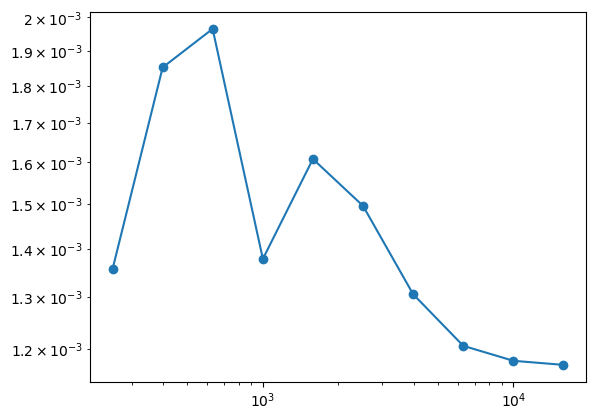

In [271]:
# Good: 0.92015

plt.loglog(nums_Vs[2:], np.abs((means[2:] - 0.9223383397233311**0.5) / 0.9223383397233311**0.5), 'o-')
# plt.loglog(nums_Vs[:-1], nums_Vs[:-1]**(-1.5) * 80, 'o-')

In [272]:
Vs_difs = [np.abs(nums_Vs[i] - nums_Vs[i+1]) for i in range(len(nums_Vs) - 1)]
eigs_difs = [np.abs(means[i]**2 - means[i+1]**2) for i in range(len(means) - 1)]

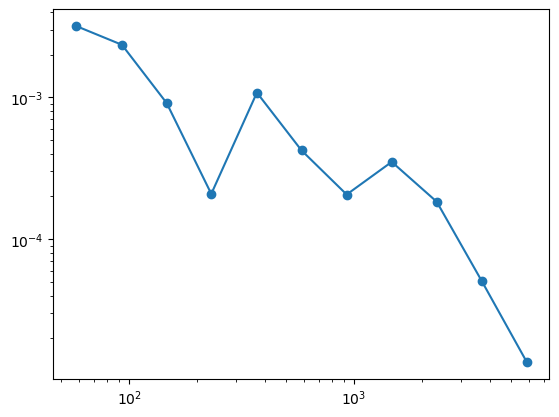

In [273]:
plt.loglog(Vs_difs, eigs_difs, 'o-')
# plt.loglog(nums_Vs, nums_Vs**(-0.33) / 100, 'o-')